In [71]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [72]:
## Create the dataframe for the model by importing the synergies CSVs

dataframe = pd.DataFrame() # init an empty DataFrame

# For each available year, read the csv as a dataframe and append it to the initial one
for year in range(2020, 2025):
    df = pd.read_csv(f'D:\\Uni\\dissertation\\data\\historic_synergies\\historic_data_{year}.csv')
    dataframe = pd.concat([dataframe, df])

# Data cleaning
dataframe = dataframe.dropna(subset=['SynergyScore'])       # Remove invalid Synergy scores
dataframe = dataframe.loc[dataframe['SynergyScore'] != 0]   # Remove rows with Synergy Score 0 (most likely errors)
dataframe = dataframe.loc[dataframe['Avg_Q'] != 0]          # Remove Qualifying outliers
# It is not necessary for the other columns, as there are no zero values (except for DNFRate, where it is possible to be 0)

print(dataframe.head())

             Driver  Season  Teammate_delta  Lap_stdev     Avg_Q     Avg_R  \
0    Lewis Hamilton    2020       -0.524481   1.428011  1.687500  1.875000   
1   Valtteri Bottas    2020        0.514455   1.689548  2.294118  5.176471   
2    Max Verstappen    2020       -0.757881   1.790402  3.117647  7.117647   
4  Daniel Ricciardo    2020       -0.409839   1.778044  7.705882  7.470588   
5      Carlos Sainz    2020       -0.128839   1.925692  8.294118  8.941176   

     DNFRate  SynergyScore  
0   0.000000     -5.830152  
1   0.000000    -13.461195  
2  11.764706    -14.383196  
4   0.000000    -12.561614  
5   5.882353    -18.307795  


In [73]:
# Normalize Synergy Score values using a MinMax Scaler

scaler = MinMaxScaler(feature_range=(0, 100))
dataframe['SynergyScore'] = scaler.fit_transform(dataframe[['SynergyScore']])

print(dataframe.head(10)[['Driver', 'Season', 'SynergyScore']])

normal_and_clean_dataframe = dataframe[['Driver', 'Season', 'SynergyScore']]
normal_and_clean_dataframe.to_csv('../../data/historic_synergies/normalised_synergies.csv')


              Driver  Season  SynergyScore
0     Lewis Hamilton    2020     97.930729
1    Valtteri Bottas    2020     74.265157
2     Max Verstappen    2020     71.405823
4   Daniel Ricciardo    2020     77.054957
5       Carlos Sainz    2020     59.234763
6    Alexander Albon    2020     40.937741
7    Charles Leclerc    2020     42.134930
8       Lando Norris    2020     64.870708
9       Pierre Gasly    2020     51.298693
10      Lance Stroll    2020     32.163305


In [74]:
# Train a Random Forest Regressor model
X = dataframe[['Teammate_delta', 'Lap_stdev', 'Avg_Q', 'Avg_R', 'DNFRate']]
y = dataframe['SynergyScore']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [82]:
predictions = model.predict(X_test)

# Cross-validation with R2
r2_cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"R^2 scores for each fold: {r2_cv_scores}")
print(f"Average R^2 score: {np.mean(r2_cv_scores):.4f}")

# Cross-validation with RMSE (negative)
rmse_cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-Validated RMSE Scores:", -rmse_cv_scores)
print("Mean CV RMSE:", -rmse_cv_scores.mean())

rmse_test = root_mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Test RMSE:", rmse_test)
print("Test MAE:", mae)
print("Test R² Score:", r2)

R^2 scores for each fold: [0.91818991 0.90180201 0.88045583 0.81102942 0.84956329]
Average R^2 score: 0.8722
Cross-Validated RMSE Scores: [6.12176645 5.75585563 6.7400813  8.88543196 7.98346073]
Mean CV RMSE: 7.097319214009728
Test RMSE: 7.04517480190799
Test MAE: 5.452296574713404
Test R² Score: 0.8916112319258487


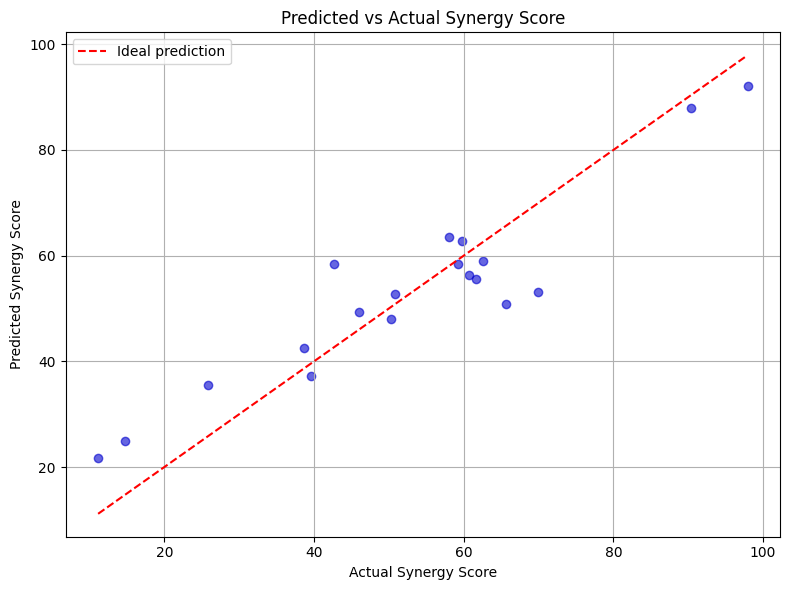

In [76]:
import matplotlib.pyplot as plt

y_test_values = y_test.values

plt.figure(figsize=(8, 6))
plt.scatter(y_test_values, predictions, color='mediumblue', alpha=0.6)
plt.plot([y_test_values.min(), y_test_values.max()],
         [y_test_values.min(), y_test_values.max()],
         color='red', linestyle='--', label='Ideal prediction')
plt.xlabel('Actual Synergy Score')
plt.ylabel('Predicted Synergy Score')
plt.title('Predicted vs Actual Synergy Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

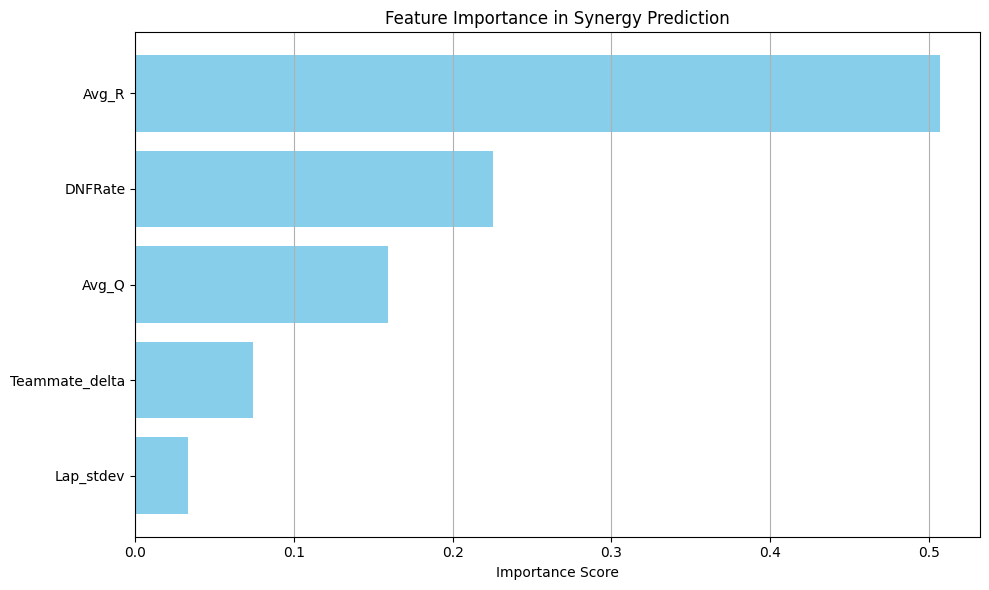

In [77]:
importances = model.feature_importances_
features = X.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_features = [features[i] for i in indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel("Importance Score")
plt.title("Feature Importance in Synergy Prediction")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score



Cross-Validated RMSE Scores: [7.29129135 5.13049462 6.7007842  9.14912749 6.74700296]
Mean CV RMSE: 7.003740124777034


---------------- XGBoost ---------------- 

Mean Squared Error: 49.634


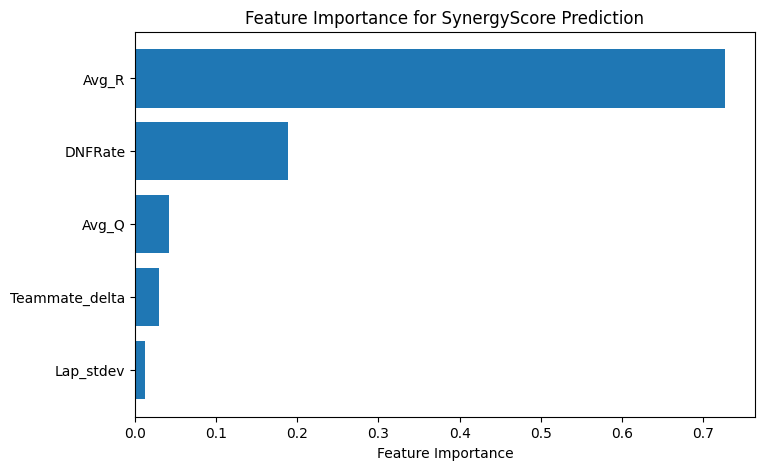

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

X = dataframe[['Teammate_delta', 'Lap_stdev', 'Avg_Q', 'Avg_R', 'DNFRate']]
y = dataframe['SynergyScore']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for SynergyScore Prediction')
plt.show()

In [84]:
# Cross-validation with R2
r2_cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"R^2 scores for each fold: {r2_cv_scores}")
print(f"Average R^2 score: {np.mean(r2_cv_scores):.4f}")

# Cross-validation with RMSE (negative)
rmse_cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-Validated RMSE Scores:", -rmse_cv_scores)
print("Mean CV RMSE:", -rmse_cv_scores.mean())

rmse_test = root_mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Test RMSE:", rmse_test)
print("Test MAE:", mae)
print("Test R² Score:", r2)

R^2 scores for each fold: [0.91818991 0.90180201 0.88045583 0.81102942 0.84956329]
Average R^2 score: 0.8722
Cross-Validated RMSE Scores: [6.12176645 5.75585563 6.7400813  8.88543196 7.98346073]
Mean CV RMSE: 7.097319214009728
Test RMSE: 7.04517480190799
Test MAE: 5.452296574713404
Test R² Score: 0.8916112319258487


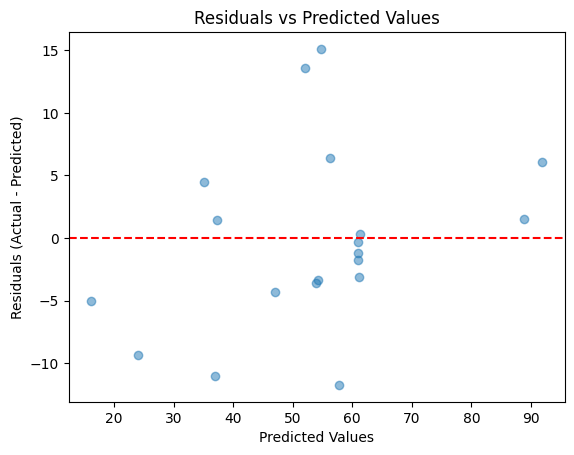

In [80]:
# Assuming y_test and y_pred are your true and predicted values
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted Values')
plt.show()

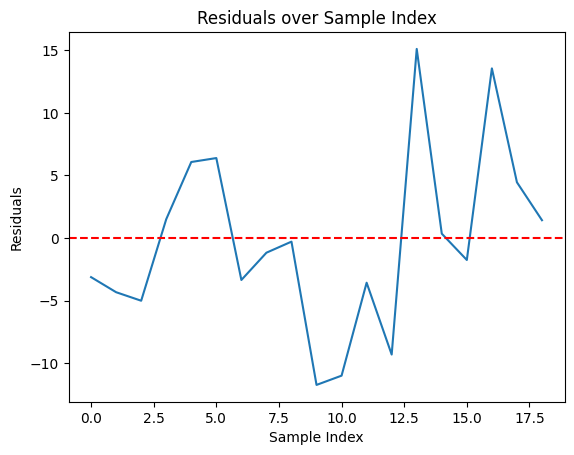

In [81]:
plt.plot(residuals.values)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Residuals')
plt.title('Residuals over Sample Index')
plt.show()